## Feature Generation - Domain Specific

This notebook is about exploring features based on the domain of bank transactions that can provide information about the satisfaction of customers

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import operator
import xgboost as xgb
from collections import defaultdict
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.utils import shuffle
import seaborn as sns

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# removing features with only one unique value

def get_feats_with_unique(data, min_unique_count):
    unique_counts = data.nunique(axis=0)
    feats_with_unique = unique_counts[unique_counts <= min_unique_count].index
    return feats_with_unique

train_unique_feats = get_feats_with_unique(train, 1)
train.drop(columns=train_unique_feats, inplace=True)

test.drop(columns=train_unique_feats, inplace=True)

# 1. Transforming features


In [4]:
# 1. Limiting the test values to max-min from train
train_describe = train.describe()
test_describe = test.describe()
for c in train.columns:
    if c == 'TARGET':
        continue

    min_cut = train_describe[c]['min']
    max_cut = train_describe[c]['max']
    
    if test_describe[c]['min'] < min_cut:
        test.loc[test[c] < min_cut, c] = min_cut
        
    if test_describe[c]['max'] > max_cut:
        test.loc[test[c] > max_cut, c] = max_cut


In [20]:
def get_model_trained(train_set, test_set, target_col, cvfold, model):
    
    train_set_x = train_set.drop([target_col], axis=1)
    train_set_y = train_set[target_col]

    x_test = xgb.DMatrix(test_set)
    x_train_full = xgb.DMatrix(train_set_x)
    
    count = 0
    test_preds = None
    train_preds = None
    
    for train_index, val_index in cvfold.split(train_set_x, train_set_y):
        x_train, x_val = train_set_x.iloc[train_index], train_set_x.iloc[val_index]
        y_train, y_val = train_set_y.iloc[train_index], train_set_y.iloc[val_index]
        
        bst = model.fit(x_train, y_train)
        pred_train = bst.predict_proba(x_train)
        train_score = roc_auc_score(y_train, pred_train[:, 1])
        
        pred_val = bst.predict_proba(x_val)
        val_score = roc_auc_score(y_val, pred_val[:, 1])
        
        print (f"K Fold {count} train_score {train_score} val score {val_score}")

        preds = bst.predict_proba(test_set)
        if test_preds is None:
            test_preds = preds
        else:
            test_preds *= preds
        
        preds = bst.predict_proba(train_set_x)
        if train_preds is None:
            train_preds = preds
        else:
            train_preds *= preds

        count += 1
    
    test_preds = test_preds ** (1.0/count)
    train_preds = train_preds ** (1.0/count)
#     full_train_score = roc_auc_score(train_set_y, train_preds[:, 1])
#     print (f"Training score after completing the k fold {full_train_score}")
    
    return train_preds, test_preds

In [10]:
from sklearn.model_selection import StratifiedKFold

In [19]:
skf = StratifiedKFold(n_splits=10, random_state=22)

In [16]:
model = xgb.XGBClassifier(max_depth=4, learning_rate=0.02, n_estimators=130, n_jobs=4, 
                          colsample_bytree=0.7, subsample=0.8, )
# param = {'max_depth': 4, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic'}
# param['nthread'] = 4
# param['eval_metric'] = 'auc'
# param['colsample_bytree'] = 0.7
# num_round = 100

In [21]:
train_preds, test_preds = get_model_trained(train, test, 'TARGET', skf, model)

K Fold 0 train_score 0.8449229121678877 val score 0.8234275231561734
K Fold 1 train_score 0.8446163126120262 val score 0.8241466180020764
K Fold 2 train_score 0.8471440247780526 val score 0.8044073969751561
K Fold 3 train_score 0.8451260989191025 val score 0.836863925708079
K Fold 4 train_score 0.8444503556187591 val score 0.8430945835936552
K Fold 5 train_score 0.8449256684899422 val score 0.8257552212617305
K Fold 6 train_score 0.84327153910899 val score 0.844506805375498
K Fold 7 train_score 0.8425136925563453 val score 0.8570015667084242
K Fold 8 train_score 0.8420254392881483 val score 0.8406044834041
K Fold 9 train_score 0.8453421085574861 val score 0.7965454503949231


In [187]:
test_preds = model.predict_proba(test.drop(['bank_acc_and_age', 'TARGET'], axis=1))
test["TARGET"]  = test_preds[:, 1]
test[["ID", "TARGET"]].to_csv("test_basic_fg_domain.csv", index=False)

In [25]:
train_preds = model.predict_proba(train.drop(['TARGET'], axis=1))
roc_auc_score(train['TARGET'], train_preds[:, 1])

0.8176068482366933

## Features interpretation

    - var15 - Age

    - var3 - Nationality

    - num_var4 - number of bank accounts

    - var38 - mortgage value with the bank

    - ind - indicator variables (claimed to be useless)

Reference: https://www.kaggle.com/c/santander-customer-satisfaction/discussion/19291#latest-116251

    - imp_ent_varX - amount for the bank office

    - imp_op_varX_comer - amount for commercial option

    - imp_sal_varX - amount for wage

There are many variants of variables

The variants can be identified with the first word from the feature name

- num, ind, delta, saldo, imp

    - saldo - varies huge from negative to positive 10^6

    - delta - starts with 0 but goes really high upto 10^10

    - var38 - whole variable

    - num - starts with 0 and goes up moderately upto 1000s

    - ind - stays between 0 and 1


## When will be customers be dissatisfied?


- A power user who had a lot of accounts with the bank and the bank failed to deliver on the results


- He/she is a new customer who had a bad experience with the first few products of the bank


- A person with lesser wage would rely heavily on bank services

In [33]:
train.loc[train['var3']==-999999, "var3"] = -1

In [54]:
train[train['var3']<16]['TARGET'].value_counts()

0    72557
1     3004
Name: TARGET, dtype: int64

In [53]:
train['var3'].value_counts()

 2      74165
 8        138
-1        116
 9        110
 3        108
 1        105
 13        98
 7         97
 4         86
 12        85
 6         82
 0         75
 10        72
 11        66
 5         63
 14        61
 15        34
 18        10
 16         9
 23         7
 17         7
 142        6
 154        6
 20         6
 31         6
 25         6
 38         6
 149        5
 153        5
 192        5
        ...  
 225        1
 169        1
 41         1
 228        1
 101        1
 165        1
 229        1
 168        1
 108        1
 238        1
 184        1
 112        1
 76         1
 77         1
 205        1
 119        1
 79         1
 182        1
 181        1
 210        1
 40         1
 211        1
 84         1
 213        1
 178        1
 177        1
 87         1
 151        1
 215        1
 191        1
Name: var3, Length: 208, dtype: int64

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1080x1080 with 0 Axes>

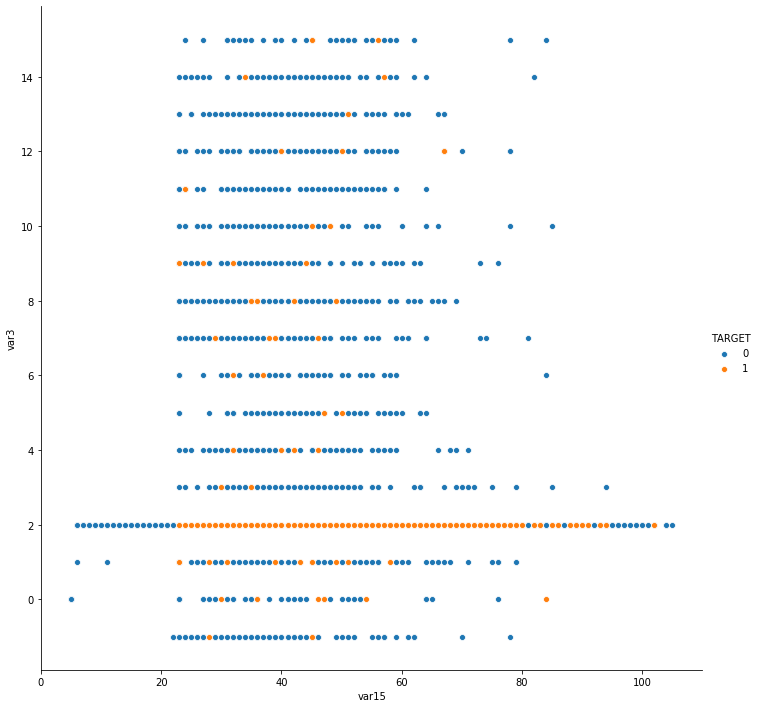

In [56]:
plt.figure(figsize=(15, 15))
g = sns.pairplot(train[train['var3']<16], x_vars=['var15'], y_vars=['var3'], hue='TARGET', size=10)

In [ ]:
train["num_var4"]

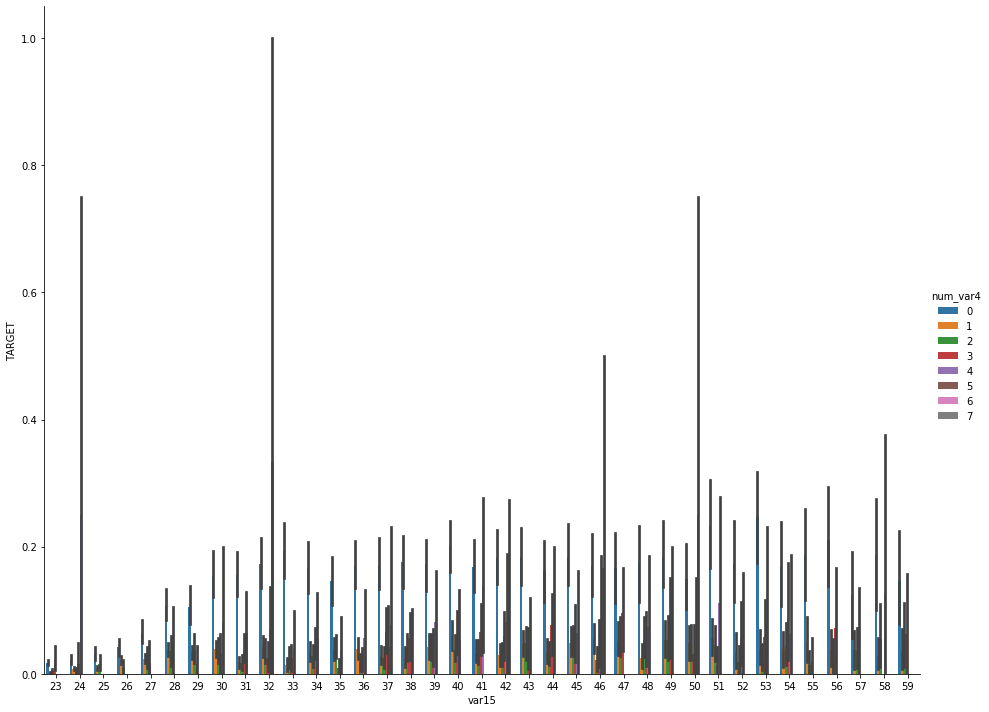

In [81]:
sns.catplot(y="TARGET", x="var15", hue="num_var4", data=train[(train["var15"]>22) & (train['var15']<60) ], kind="bar", height=10, aspect=1.3)


In [75]:
train[train['num_var4'].isin([0, 1, 6, 7])]['TARGET'].value_counts()

0    55288
1     2429
Name: TARGET, dtype: int64

In [115]:
train[(train['num_var4'].isin([0,1,2])) & (train['var15']>27) & (train['var15']<80)]['TARGET'].value_counts()

0    30004
1     2289
Name: TARGET, dtype: int64

In [105]:
# new feature
train["bank_acc_and_age"] = 0
train.loc[(train['num_var4'].isin([0,1,2])) & (train['var15']>27), "bank_acc_and_age"] = 1

In [108]:
train_sub = train[train['bank_acc_and_age']==1]

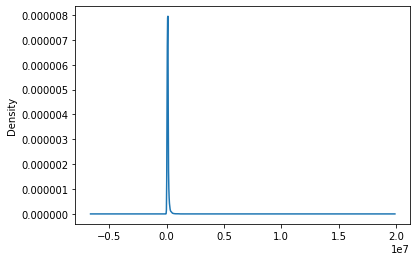

In [117]:
train_sub["var38"].plot(kind="kde")

In [128]:
np.percentile(train_sub["var38"], 98)

333012.65099999995

In [130]:
train_sub[(train_sub["TARGET"]==1) & (train_sub["var38"] < np.percentile(train_sub["var38"], 98))]["var38"].describe()

count      2275.000000
mean      90784.928705
std       44322.686601
min       11136.630000
25%       57489.810000
50%       85416.120000
75%      117310.979016
max      329182.200000
Name: var38, dtype: float64

In [131]:
train_sub[(train_sub["TARGET"]==0) & (train_sub["var38"] < np.percentile(train_sub["var38"], 98))]["var38"].describe()

count     29931.000000
mean     105273.410177
std       50541.394296
min        6480.660000
25%       68659.875000
50%      105453.450000
75%      117310.979016
max      332991.450000
Name: var38, dtype: float64

In [154]:
np.percentile(train_sub["imp_ent_var16_ult1"], 9)

0.0

In [149]:
train.columns[train.columns.map(lambda x: x.startswith("imp_ent"))]

Index(['imp_ent_var16_ult1'], dtype='object')

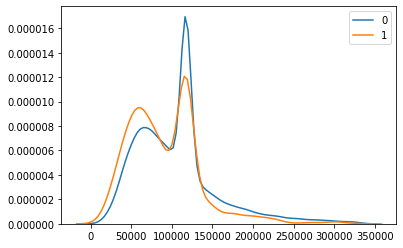

In [129]:
sns.kdeplot(train_sub[(train_sub["TARGET"]==0) & (train_sub["var38"] < np.percentile(train_sub["var38"], 98))]["var38"], label="0")
sns.kdeplot(train_sub[(train_sub["TARGET"]==1) & (train_sub["var38"] < np.percentile(train_sub["var38"], 98))]["var38"], label="1")
plt.legend()

In [165]:
train_sub[(train_sub["TARGET"]==0)]["num_var35"].describe()

count    30556.000000
mean         3.193612
std          2.341326
min          0.000000
25%          3.000000
50%          3.000000
75%          6.000000
max         36.000000
Name: num_var35, dtype: float64

In [164]:
train_sub[(train_sub["TARGET"]==1)]["num_var35"].describe()

count    2308.000000
mean        1.510399
std         2.258035
min         0.000000
25%         0.000000
50%         0.000000
75%         3.000000
max        21.000000
Name: num_var35, dtype: float64

In [163]:
pd.DataFrame([train.columns[:-1], model.feature_importances_]).T.sort_values([1], ascending=False)

,0,1
135,num_var35,0.086288
80,num_var4,0.0715472
165,saldo_var30,0.0696424
2,var15,0.0672165
253,num_meses_var5_ult3,0.0520456
58,ind_var30,0.0352521
89,num_var13_0,0.0318361
297,saldo_medio_var5_hace3,0.0240335
125,num_var30_0,0.0226504
51,ind_var26_cte,0.0181902


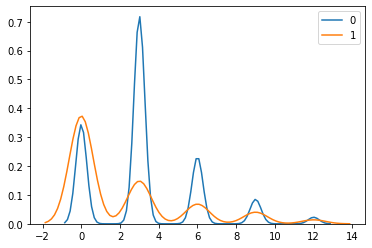

In [168]:
sns.kdeplot(train[(train["TARGET"]==0) & (train["num_var35"]<15) ]["num_var35"], label="0")
sns.kdeplot(train[(train["TARGET"]==1) & (train["num_var35"]<15) ]["num_var35"], label="1")
plt.legend()

In [106]:
test["bank_acc_and_age"] = 0
test.loc[(test['num_var4'].isin([0,1,2])) & (test['var15']>27), "bank_acc_and_age"] = 1

In [169]:
# adding num_var35 into our new feature as an inverse relation

In [170]:
train['bank_acc_and_age'] *= 100
train["bank_acc_and_age"] /= (train["num_var35"]+1)

In [171]:
test['bank_acc_and_age'] *= 100
test["bank_acc_and_age"] /= (test["num_var35"]+1)

In [177]:
model2 = xgb.XGBClassifier(max_depth=4, learning_rate=0.02, n_estimators=130, n_jobs=4, 
                          colsample_bytree=0.7, subsample=0.8, )
train_preds, test_preds = get_model_trained(train, test, 'TARGET', skf, model2)

K Fold 0 train_score 0.8412566337283574 val score 0.8296477731946192
K Fold 1 train_score 0.8422024869211567 val score 0.8240738213077743
K Fold 2 train_score 0.8455680099981291 val score 0.8059725127536801
K Fold 3 train_score 0.8431290720187219 val score 0.8346421848188094
K Fold 4 train_score 0.8427764685001086 val score 0.8407274568950414
K Fold 5 train_score 0.8432160296760602 val score 0.8238260721577757
K Fold 6 train_score 0.8419075693509381 val score 0.8441461848624933
K Fold 7 train_score 0.8414675640545491 val score 0.8539787249823785
K Fold 8 train_score 0.841141569794436 val score 0.837572706935123
K Fold 9 train_score 0.8455645841183588 val score 0.8013826873031092


In [188]:
test_preds = model2.predict_proba(test.drop(['TARGET'], axis=1))
test["TARGET"]  = test_preds[:, 1]
test[["ID", "TARGET"]].to_csv("test_adv_fg_domain.csv", index=False)

In [178]:
train_preds = model2.predict_proba(train.drop(['TARGET'], axis=1))
roc_auc_score(train['TARGET'], train_preds[:, 1])

0.8280667539640817

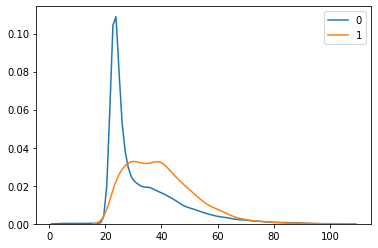

In [58]:
sns.kdeplot(train[(train['var3']<16) & (train['TARGET']==0)]['var15'], label="0")
sns.kdeplot(train[(train['var3']<16) & (train['TARGET']==1)]['var15'], label="1")
plt.legend()